In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import time as t

from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord, solar_system_ephemeris, get_body_barycentric_posvel, CartesianRepresentation, CartesianDifferential
from astropy.time import Time

import scipy.integrate as integrate
import scipy.optimize as optimize

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'

# plt.style.use('default')

In [122]:
def hyperbolic_mean_to_eccentric_anomaly(M, e):
    '''
    Convert hyperbolic mean anomaly to hyperbolic eccentric anomaly using Newton-Raphson method:
    
    `M = e * sinh(F) - F`

    Parameters
    ----------
    M : float
        Hyperbolic mean anomaly in radians
    e : float
        Eccentricity (e > 1 for hyperbolic orbits)

    Returns
    -------
    F : float
        Hyperbolic eccentric anomaly in radians
    '''
    if e <= 1:
        raise ValueError("Eccentricity must be greater than 1 for hyperbolic orbits.")

    def func(F):
        return e * np.sinh(F) - F - M
    def deriv(F):
        return e * np.cosh(F) - 1
    
    # Initial guess: F approx M for small M, else log(2M/e)
    F0 = M if abs(M) < 1 else np.log(2 * abs(M) / e) * np.sign(M)

    # Performing Newton-Raphson using scipy.optimize
    F = optimize.newton(func, F0, fprime=deriv, tol=1e-10, maxiter=1000)

    # # Newton-Raphson iterations
    # for k in range(max_iter):
    #     # Calculating next correction
    #     delta_F = (M - (e * np.sinh(F) - F)) / (e * np.cosh(F) - 1)
        
    #     # Calculating next approximation
    #     F += delta_F

    #     # Check for convergence
    #     if abs(delta_F) < tol:
    #         break

    # return F, k+1  # Return the number of iterations as well
    
    return F

def mean_to_eccentric_anomaly(M, e):
    '''
    Convert mean anomaly to eccentric anomaly using Newton-Raphson method:
    
    `M = E - e * sin(E)`

    Parameters
    ----------
    M : float
        Mean anomaly in radians
    e : float
        Eccentricity (e < 1 for elliptical orbits)

    Returns
    -------
    E : float
        Eccentric anomaly in radians
    '''
    if e >= 1:
        raise ValueError("Eccentricity must be less than 1 for elliptical orbits.")
    
    def func(E):
        return E - e * np.sin(E) - M
    def deriv(E):
        return 1 - e * np.cos(E)
    
    # Initial guess: E approx M for small e, else pi
    E0 = np.pi if e > 0.8 else M 

    # Performing Newton-Raphson using scipy.optimize
    E = optimize.newton(func, E0, fprime=deriv)

    return E

def OEtoRV(orbital_elements: dict) -> dict:
    '''
    Convert orbital elements to state vectors.

    Parameters
    ----------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)

    Returns
    -------
    (r, v) : tuple of np.ndarray
        Position (r) and velocity (v) vectors in heliocentric frame [km] and [km/s]
    '''
    # Unpacking orbital elements and converting to appropriate units
    a = orbital_elements['a'].to(u.km).value
    e = orbital_elements['e']
    i = orbital_elements['i'].to(u.rad).value
    Omega = orbital_elements['Omega'].to(u.rad).value
    omega = orbital_elements['omega'].to(u.rad).value

    # Checking if mean anomaly or true anomaly is given:
    if 'M' in orbital_elements:
        M = orbital_elements['M'].to(u.rad).value
    elif 'nu' in orbital_elements:
        nu = orbital_elements['nu'].to(u.rad).value
    else:
        raise ValueError("Either mean anomaly (M) or true anomaly (nu) must be provided.")

    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]
    h = np.sqrt(abs(mu_sun * a * (e**2 - 1)))  # Specific angular momentum [km^2/s]

    # Defining rotational matrices
    Rz_Omega = np.array([
        [ np.cos(Omega), np.sin(Omega), 0.0],
        [-np.sin(Omega), np.cos(Omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    Rx_i = np.array([
        [1.0,  0.0,       0.0],
        [0.0,  np.cos(i), np.sin(i)],
        [0.0, -np.sin(i), np.cos(i)]
    ])

    Rz_omega = np.array([
        [ np.cos(omega), np.sin(omega), 0.0],
        [-np.sin(omega), np.cos(omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    # DCM to go from inertial (heliocentric) frame to orbital frame
    R_OI = Rz_omega @ Rx_i @ Rz_Omega

    # Calculating position of object in the orbital frame
    # Solving Kepler's equation for Eccentric Anomaly (E) using Newton-Raphson method
    if 'M' in orbital_elements:
        if e < 1:
            # Elliptical orbit case
            E = mean_to_eccentric_anomaly(M, e)

            # Calculating true anomaly (nu) from eccentric anomaly (E)
            nu = 2 * np.arctan2( np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2), 1 )

            # Calculating distance (r) from the focus (Sun) to the object
            r_mag = (a * (1 - e**2)) / (1 + e * np.cos(nu))

        elif e > 1:
            # Hyperbolic orbit case
            F = hyperbolic_mean_to_eccentric_anomaly(M, e)

            # Calculating true anomaly (nu) from hyperbolic eccentric anomaly (F)
            nu = 2 * np.arctan2( np.sqrt((e + 1) / (e - 1)) * np.tanh(F / 2), 1 )

            # Calculating distance (r) from the focus (Sun) to the object
            r_mag = (a * (1 - e**2)) / (1 + e * np.cos(nu))

        else:
            raise ValueError("Eccentricity cannot be equal to 1 (parabolic orbits not supported).")
    
    else:
        # If true anomaly is given directly
        r_mag = (a * (1 - e**2)) / (1 + e * np.cos(nu))

    # Position in orbital frame [km]
    r_orbital = np.array([
        r_mag * np.cos(nu),
        r_mag * np.sin(nu),
        0.0
    ])

    # Velocity in orbital frame [km/s]
    v_orbital = np.array([
        (mu_sun / h) * (-np.sin(nu)),
        (mu_sun / h) * (e + np.cos(nu)),
        0.0
    ])

    # Rotating position and velocity to heliocentric frame
    r_heliocentric = (np.transpose(R_OI) @ r_orbital * u.km).to(u.au)
    v_heliocentric = np.transpose(R_OI) @ v_orbital * u.km / u.s

    return (r_heliocentric, v_heliocentric)

def R_OI(orbital_elements: dict) -> dict:
    '''
    Computes rotation matrix from inertial frame to orbital frame.

    Parameters
    ----------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)

    Returns
    -------
    R_OI : NDArray
        Direction cosine matrix from inertial to orbital frame
    '''
    # Unpacking orbital elements and converting to appropriate units
    a = orbital_elements['a'].to(u.km).value
    e = orbital_elements['e']
    i = orbital_elements['i'].to(u.rad).value
    Omega = orbital_elements['Omega'].to(u.rad).value
    omega = orbital_elements['omega'].to(u.rad).value

    # Checking if mean anomaly or true anomaly is given:
    if 'M' in orbital_elements:
        M = orbital_elements['M'].to(u.rad).value
    elif 'nu' in orbital_elements:
        nu = orbital_elements['nu'].to(u.rad).value
    else:
        raise ValueError("Either mean anomaly (M) or true anomaly (nu) must be provided.")

    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]
    h = np.sqrt(abs(mu_sun * a * (e**2 - 1)))  # Specific angular momentum [km^2/s]

    # Defining rotational matrices
    Rz_Omega = np.array([
        [ np.cos(Omega), np.sin(Omega), 0.0],
        [-np.sin(Omega), np.cos(Omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    Rx_i = np.array([
        [1.0,  0.0,       0.0],
        [0.0,  np.cos(i), np.sin(i)],
        [0.0, -np.sin(i), np.cos(i)]
    ])

    Rz_omega = np.array([
        [ np.cos(omega), np.sin(omega), 0.0],
        [-np.sin(omega), np.cos(omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    # DCM to go from inertial (heliocentric) frame to orbital frame
    R_OI = Rz_omega @ Rx_i @ Rz_Omega

    return R_OI

def R_BI(sc_elements):
    '''
    Computes rotation matrix from inertial frame to spacecraft body frame.

    Parameters
    ----------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)

    Returns
    -------
    R_BI : NDArray
        Direction cosine matrix from inertial to spacecraft body frame
    '''
    # Calculating heliocentric state vectors
    r, v = OEtoRV(sc_elements)

    # Calculating velocity unit vector (along +x body axis)
    v_unit = v.value / np.linalg.norm(v.value)

    # Calculating radial vector (along +y body axis)
    r_unit = r.value / np.linalg.norm(r.value)

    # Calculating angular momentum vector (along +z body axis)
    h_unit = np.cross(r_unit, v_unit)
    h_unit /= np.linalg.norm(h_unit)

    # Constructing DCM from inertial to body frame
    R_BI = np.vstack((v_unit, r_unit, h_unit))

    return R_BI
    

def helio_RV_to_bary_RV(r_heliocentric, v_heliocentric, M, a, perihelion_epoch):
    '''
    Convert heliocentric state vectors to barycentric state vectors.

    Parameters
    ----------
    r_heliocentric : np.ndarray
        Position vector in heliocentric frame [km]
    v_heliocentric : np.ndarray
        Velocity vector in heliocentric frame [km/s]
    a : astropy Quantity with length unit
        Heliocentric semi-major axis
    M : astropy Quantity with angle unit
        Mean anomaly
    perihelion_epoch : astropy Time object
        Epoch of the perihelion passage

    Returns
    -------
    (r, v) : tuple of np.ndarray
        Position (r) and velocity (v) vectors in barycentric frame [km] and [km/s]
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Converting values
    a = a.to(u.km).value
    M = M.to(u.rad).value

    # Now, we must find what time these elements were valid at, and get the Sun's state vector at that time
    # The epoch given is the perhelion passage time, so we need to propagate to the time of interest
    # First, calculate mean motion (n)
    n = np.sqrt(mu_sun / abs(a)**3)  # Mean motion [rad/s]

    # Now, using M = n * (t - perihelion_epoch), we can find the time of interest
    # Rearranging gives t = M/n + perihelion_epoch
    t = (M / n) * u.s + perihelion_epoch

    # The time t is the time at which the orbital elements are valid
    # We will use this time to get the Sun's state vector
    with solar_system_ephemeris.set('jpl'):
        sun_posvel = get_body_barycentric_posvel('sun', t)
    
    sun_pos = sun_posvel[0].get_xyz().to(u.km)
    sun_vel = sun_posvel[1].get_xyz().to(u.km / u.s)

    # Transforming to barycentric frame
    r_barycentric = r_heliocentric + sun_pos
    v_barycentric = v_heliocentric + sun_vel

    return (r_barycentric, v_barycentric)

def RVtoOE(r_barycentric, v_barycentric):
    '''
    Convert barycentric state vectors to barycentric orbital elements.

    Parameters
    ----------
    r_barycentric : np.ndarray
        Position vector in barycentric frame [km]
    v_barycentric : np.ndarray
        Velocity vector in barycentric frame [km/s]

    Returns
    -------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)
    '''
    r_barycentric = r_barycentric.to(u.km).value
    v_barycentric = v_barycentric.to(u.km / u.s).value

    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Now, we need to convert the barycentric state vector back to barycentric orbital elements
    r_mag_barycentric = np.linalg.norm(r_barycentric)
    v_mag_barycentric = np.linalg.norm(v_barycentric)

    # Specific angular momentum vector
    h_barycentric = np.cross(r_barycentric, v_barycentric)
    h_mag_barycentric = np.linalg.norm(h_barycentric)

    # Calculating semimajor axis (a) [km]
    a = 1 / (2 / np.linalg.norm(r_barycentric) - np.linalg.norm(v_barycentric)**2 / mu_sun)

    # Calculating eccentricity (e)
    e_vector = (1/mu_sun) * (np.cross(v_barycentric, h_barycentric) - mu_sun*r_barycentric/r_mag_barycentric)
    e = np.linalg.norm(e_vector)

    # Calculating orbital frame basis vectors
    i_e = e_vector / e  # Unit vector in direction of eccentricity
    i_h = h_barycentric / h_mag_barycentric  # Unit vector in direction of angular momentum
    i_y = np.cross(i_h, i_e)  # Unit vector perpendicular to both

    # Constructing DCM from inertial to orbital frame
    R_OI_barycentric = np.vstack((i_e, i_y, i_h))

    # Calculating inclination (i) [rad]
    i = np.arccos(R_OI_barycentric[2, 2])

    # Calculating longitude of ascending node (Omega) [rad]
    Omega = np.arctan2(i_h[0]/np.sin(i), -i_h[1]/np.sin(i))

    if Omega < 0:
        Omega += 2 * np.pi

    # Calculating argument of perihelion (omega) [rad]
    omega = np.arctan2(i_e[2]/np.sin(i), i_y[2]/np.sin(i))

    if omega < 0:
        omega += 2 * np.pi

    # Calculating true anomaly (nu) [rad]
    r_orbital = R_OI_barycentric @ r_barycentric
    nu = np.arctan2(r_orbital[1], r_orbital[0])

    # Calculating hyperbolic eccentric anomaly (F) [rad]
    F = 2 * np.arctanh( np.tan(nu / 2) * np.sqrt((e - 1) / (e + 1)) )

    # Calculating hyperbolic mean anomaly (M) [rad]
    M = e * np.sinh(F) - F

    # Inserting values into dictionary and converting to appropriate units
    orbital_elements = {
        'a': (a * u.km).to(u.au),
        'e': e,
        'i': (i * u.rad).to(u.deg),
        'Omega': (Omega * u.rad).to(u.deg),
        'omega': (omega * u.rad).to(u.deg),
        'M': (M * u.rad).to(u.deg),
    }

    return orbital_elements

def OEtoRAD(a: u.Quantity, e: float, i_deg: u.Quantity, Omega_deg: u.Quantity, omega_deg: u.Quantity, is_barycentric=False) -> tuple[float, float, np.ndarray, np.ndarray]:
    '''
    Convert orbital elements to RA and Dec of the incoming velocity vector if an ISO.

    Parameters
    ----------
    a : float
        Semi-major axis of the orbit (in AU).
    e : float
        Eccentricity of the orbit.
    i_deg : float
        Inclination of the orbit (in degrees).
    Omega_deg : float
        Longitude of the ascending node (in degrees).
    omega_deg : float
        Argument of perihelion (in degrees).
    is_barycentric : bool
        If True, convert to barycentric coordinates.

    Returns
    -------
    ra : float
        Right Ascension of the incoming velocity vector (in degrees).
    dec : float
        Declination of the incoming velocity vector (in degrees).
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Convert angles from degrees to radians
    i = i_deg.to(u.rad).value
    Omega = Omega_deg.to(u.rad).value
    omega = omega_deg.to(u.rad).value

    # Convert semi-major axis to meters
    a = a.to(u.km).value

    # Hyperbola: e > 1, a < 0
    # Asymptote true anomaly magnitude:
    # cos(nu_inf) = -1/e
    nu_inf = np.arccos(-1.0 / e)      # in radians
    nu_in = -nu_inf                   # incoming branch (before perihelion)

    # Specific angular momentum (magnitude) h = sqrt(mu * a * (e^2 - 1))
    h = np.sqrt(-mu_sun * abs(a) * (1.0 - e**2))

    # Distance at true anomaly nu:
    r = (a * (1.0 - e**2)) / (1.0 + e * np.cos(nu_in))   # km
    print(1 + e * np.cos(nu_in))
    
    # Radial and transverse velocities in perifocal frame:
    v_r = (mu_sun / h) * e * np.sin(nu_in)
    v_t = (mu_sun / h) * (1.0 + e * np.cos(nu_in))

    # Position in perifocal frame
    r_pf = np.array([r * np.cos(nu_in), r * np.sin(nu_in), 0.0])

    # Velocity in perifocal frame
    v_pf = np.array([v_r * np.cos(nu_in) - v_t * np.sin(nu_in),
                     v_r * np.sin(nu_in) + v_t * np.cos(nu_in),
                     0.0])
    
    # Rotation matrix from perifocal -> ECI (ICRS/ecliptic depending on elements)
    # R = R_z(Omega) @ R_x(i) @ R_z(omega) (3-1-3 rotation)
    Rz_Omega = np.array([
        [np.cos(Omega), -np.sin(Omega), 0.0],
        [np.sin(Omega),  np.cos(Omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    Rx_i = np.array([
        [1.0, 0.0,        0.0],
        [0.0, np.cos(i), -np.sin(i)],
        [0.0, np.sin(i),  np.cos(i)]
    ])

    Rz_omega = np.array([
        [np.cos(omega), -np.sin(omega), 0.0],
        [np.sin(omega),  np.cos(omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    R = Rz_Omega @ Rx_i @ Rz_omega

    r_eci = R @ r_pf   # km
    v_eci = R @ v_pf   # km/s

    # Incoming velocity vector is v_eci (points toward Sun for incoming object).
    # Radiant is opposite direction (the direction it came from)
    v_unit = v_eci / np.linalg.norm(v_eci)
    radiant_unit = -v_unit

    # Convert to RA, Dec (ICRS) using cartesian -> skycoord
    # Coordinates expect units; astropy's SkyCoord.from_cartesian wants cartesian representation.
    sc = SkyCoord(x=radiant_unit[0], y=radiant_unit[1], z=radiant_unit[2],
                  representation_type='cartesian', frame='icrs')
    
    ra = sc.spherical.lon.deg
    dec = sc.spherical.lat.deg
    
    return ra * u.deg, dec * u.deg, v_eci * u.km / u.s, r_eci * u.km

def period(a):
    '''
    Calculate the orbital period given the semi-major axis.

    Parameters
    ----------
    a : astropy Quantity with length unit
        Semi-major axis of the orbit.

    Returns
    -------
    T : astropy Quantity with time unit
        Orbital period.
    '''
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]
    a_km = a.to(u.km).value

    T = 2 * np.pi * np.sqrt(a_km**3 / mu_sun) * u.s

    return T

## Functions to propagate ISO state

In [3]:
def get_iso_state(t, iso_elements: dict):
    '''
    Returns r, v of ISO at time t (seconds from perihelion).
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    a = iso_elements['a'].to(u.km).value # Should be negative for hyperbola
    e = iso_elements['e']
    n = np.sqrt(mu_sun / -a**3) # Mean motion for hyperbola
    
    M = n * t # Mean Anomaly
    iso_elements['M'] = M * u.rad
    
    return OEtoRV(iso_elements)

def get_sc_state(t, sc_elements: dict):
    '''
    Returns r, v of SC at time t (seconds from perihelion).
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    a = sc_elements['a'].to(u.km).value
    e = sc_elements['e']
    n = np.sqrt(mu_sun / a**3) # Mean motion for ellipse
    
    M = n * t # Mean Anomaly
    sc_elements['M'] = M * u.rad
    
    return OEtoRV(sc_elements)

In [4]:
oumuamua_heliocentric_elements = {
    'a': -1.27234500742808 * u.au,  # Semi-major axis
    'e': 1.201133796102373,      # Eccentricity
    'i': 122.7417062847286 * u.deg,  # Inclination
    'Omega': 24.59690955523242 * u.deg,  # Longitude of ascending node
    'omega': 241.8105360304898 * u.deg,  # Argument of perihelion
    'M': 0 * u.deg,  # Mean anomaly
    'epoch': Time('2458006.007321375231', format='jd', scale='tdb')  # Time of perihelion passage
}

borisov_heliocentric_elements = {
    'a': -0.8514922551937886 * u.au,  # Semi-major axis
    'e': 3.356475782676596,      # Eccentricity
    'i': 44.05264247909138 * u.deg,  # Inclination
    'Omega': 308.1477292269942 * u.deg,  # Longitude of ascending node
    'omega': 209.1236864378081 * u.deg,  # Argument of perihelion
    'M': 0 * u.deg,  # Mean anomaly
    'epoch': Time('2458826.052845906059', format='jd', scale='tdb')  # Time of perihelion passage
}

atlas_heliocentric_elements = {
    'a': -0.263915917517816 * u.au,  # Semi-major axis
    'e': 6.139587836355706,      # Eccentricity
    'i': 175.1131015287974 * u.deg,  # Inclination
    'Omega': 322.1568699043938 * u.deg,  # Longitude of ascending node
    'omega': 128.0099421020839 * u.deg,  # Argument of perihelion
    'M': 0 * u.deg,  # Mean anomaly
    'epoch': Time('2460977.981439259343', format='jd', scale='tdb')  # Time of perihelion passage
}

characteristic_heliocentric_elements = {
    'a': np.mean([oumuamua_heliocentric_elements['a'].value,
                  borisov_heliocentric_elements['a'].value,
                  atlas_heliocentric_elements['a'].value]) * u.au,
    'e': np.mean([oumuamua_heliocentric_elements['e'],
                  borisov_heliocentric_elements['e'],
                  atlas_heliocentric_elements['e']]),
    'i': np.mean([oumuamua_heliocentric_elements['i'].value,
                  borisov_heliocentric_elements['i'].value,
                  atlas_heliocentric_elements['i'].value]) * u.deg,
    'Omega': np.mean([oumuamua_heliocentric_elements['Omega'].value,
                      borisov_heliocentric_elements['Omega'].value,
                      atlas_heliocentric_elements['Omega'].value]) * u.deg,
    'omega': np.mean([oumuamua_heliocentric_elements['omega'].value,
                      borisov_heliocentric_elements['omega'].value,
                      atlas_heliocentric_elements['omega'].value]) * u.deg,
    'M': 0 * u.deg,  # Mean anomaly
    'epoch': Time('2459000.0', format='jd', scale='tdb')  # Arbitrary epoch
}

print(characteristic_heliocentric_elements)

{'a': <Quantity -0.79591773 AU>, 'e': np.float64(3.565732471711558), 'i': <Quantity 113.9691501 deg>, 'Omega': <Quantity 218.3005029 deg>, 'omega': <Quantity 192.98138819 deg>, 'M': <Quantity 0. deg>, 'epoch': <Time object: scale='tdb' format='jd' value=2459000.0>}


In [76]:
sc_elements = {
    'a': 1 * u.au,
    'e': 0,
    'i': 0 * u.deg,
    'Omega': 0 * u.deg,
    'omega': 0 * u.deg,
    'nu': 180 * u.deg
}

In [6]:
t_start = 0
t_end = period(sc_elements['a']).to(u.s).value

sc_ts = np.linspace(t_start, t_end, 1000)

sc_states = np.zeros((len(sc_ts), 6))

for i, t in enumerate(sc_ts):
    r_sc, v_sc = get_sc_state(t, sc_elements)
    sc_states[i, :3] = r_sc.to(u.au).value
    sc_states[i, 3:] = v_sc.to(u.km / u.s).value

In [7]:
t_start = -100 * 24 * 3600  # 100 days before perihelion
t_end = 100 * 24 * 3600     # 100 days after perihelion

iso_ts = np.linspace(t_start, t_end, 1000)

oumuamua_iso_states = np.zeros((len(iso_ts), 6))  # Assuming 3 for position and 3 for velocity
borisov_iso_states = np.zeros((len(iso_ts), 6))  # Assuming 3 for position and 3 for velocity
atlas_iso_states = np.zeros((len(iso_ts), 6))  # Assuming 3 for position and 3 for velocity
characteristic_iso_states = np.zeros((len(iso_ts), 6))  # Assuming 3 for position and 3 for velocity

for i, t in enumerate(iso_ts):
    r, v = get_iso_state(t, oumuamua_heliocentric_elements)
    oumuamua_iso_states[i, :3] = r.to(u.au).value
    oumuamua_iso_states[i, 3:] = v.to(u.km / u.s).value

    r, v = get_iso_state(t, borisov_heliocentric_elements)
    borisov_iso_states[i, :3] = r.to(u.au).value
    borisov_iso_states[i, 3:] = v.to(u.km / u.s).value

    r, v = get_iso_state(t, atlas_heliocentric_elements)
    atlas_iso_states[i, :3] = r.to(u.au).value
    atlas_iso_states[i, 3:] = v.to(u.km / u.s).value

    r, v = get_iso_state(t, characteristic_heliocentric_elements)
    characteristic_iso_states[i, :3] = r.to(u.au).value
    characteristic_iso_states[i, 3:] = v.to(u.km / u.s).value

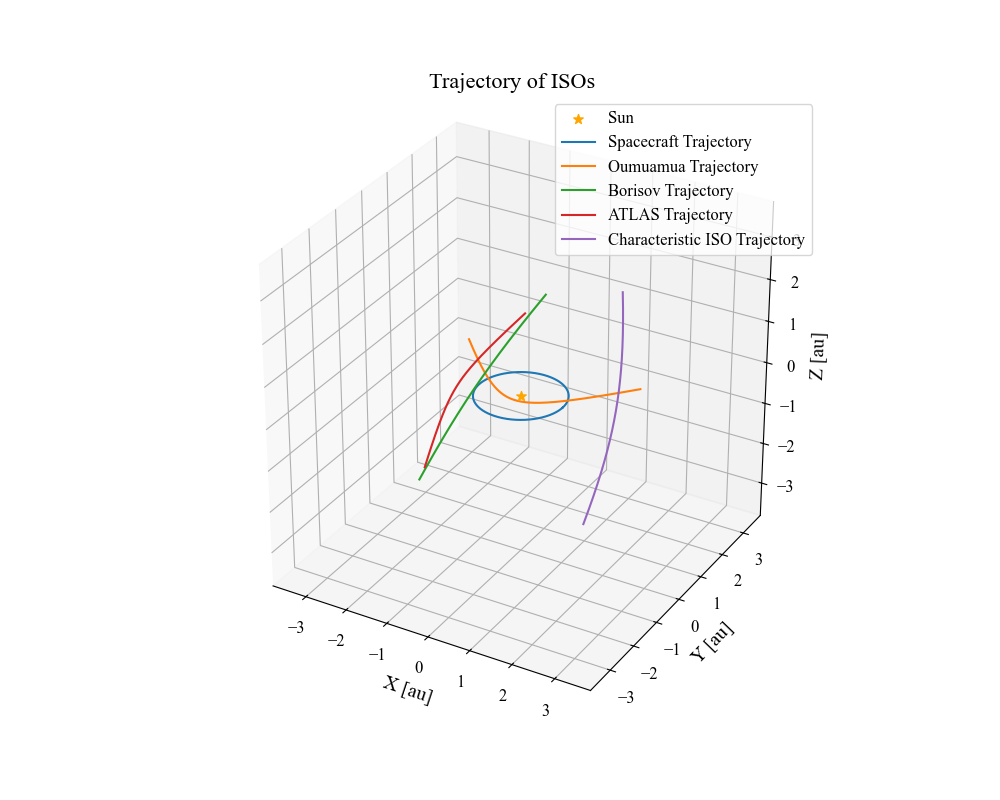

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(0, 0, 0, color='orange', s=50, label='Sun', marker='*')

ax.plot(sc_states[:, 0], sc_states[:, 1], sc_states[:, 2], label='Spacecraft Trajectory')

ax.plot(oumuamua_iso_states[:, 0], oumuamua_iso_states[:, 1], oumuamua_iso_states[:, 2], label='Oumuamua Trajectory')
ax.plot(borisov_iso_states[:, 0], borisov_iso_states[:, 1], borisov_iso_states[:, 2], label='Borisov Trajectory')
ax.plot(atlas_iso_states[:, 0], atlas_iso_states[:, 1], atlas_iso_states[:, 2], label='ATLAS Trajectory')
ax.plot(characteristic_iso_states[:, 0], characteristic_iso_states[:, 1], characteristic_iso_states[:, 2], label='Characteristic ISO Trajectory')

max_dist = np.amax([np.abs(oumuamua_iso_states[:, :3]), np.abs(borisov_iso_states[:, :3]), np.abs(atlas_iso_states[:, :3]), np.abs(characteristic_iso_states[:, :3])])

ax.set_xlim([-max_dist, max_dist])
ax.set_ylim([-max_dist, max_dist])
ax.set_zlim([-max_dist, max_dist])

ax.set_aspect('equal')

ax.set_xlabel('X [au]')
ax.set_ylabel('Y [au]')
ax.set_zlabel('Z [au]')
ax.set_title('Trajectory of ISOs')
ax.legend()

plt.show()

## Plotting intercept trajectory

In [141]:
def equations_of_motion(t, x, a_electric):
    '''
    Calculates the derivatives of the state vector x at time t due to both solar gravity and electric thrust.

    Parameters
    ----------
    t : float
        Current time [s]
    x : NDArray
        Current state vector (1x6)
    a_electric : NDArray
        Electric thrust acceleration vector (1x3)

    Returns
    -------
    x_dot : NDArray
        Derivatives of the state vector (1x6)
    '''
    state = x

    # Defining constants
    mu_sun = c.GM_sun.to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Unpack the state vector
    r, v = state[:3], state[3:]

    # Magnitude of the position vector
    r_mag = np.linalg.norm(r)

    # Magnitude of the velocity vector
    v_mag = np.linalg.norm(v)

    # Calculate the gravitational acceleration
    a_grav = -mu_sun / r_mag**3 * r

    # Calculate the electric thrust acceleration (in the direction of motion)
    a_electric = a_electric.to(u.km / u.s**2).value * (v / v_mag)

    # Total acceleration
    a = a_grav + a_electric

    state_dot = np.concatenate((v, a))

    # Return the derivatives
    return state_dot


def propagate_intercept(t_span, initial_state, a_electric, target_func=None):
    '''
    Integrates the spacecraft trajectory under solar gravity and electric thrust.

    Parameters
    ----------
    t_span : NDArray
        Time span for integration [s]
    initial_state : NDArray
        Initial state vector (1x6)
    a_electric : NDArray
        Electric thrust acceleration vector (1x3)
    target_func : function
        Function that returns the target state vector at time t

    Returns

    '''
    # Time array for integration
    ts = np.linspace(t_span[0].to(u.s).value, t_span[1].to(u.s).value, 1000)

    # Integrating the equations of motion using scipy.integrate.solve_ivp
    sol = integrate.solve_ivp(equations_of_motion, [t_span[0].to(u.s).value, t_span[1].to(u.s).value], initial_state, t_eval=ts, args=(a_electric.to(u.km / u.s**2),), rtol=1e-9, atol=1e-12)

    return sol

def analyze_interception_scenario(iso_elements: dict, sc_parking_elements: dict, sim_params: dict):
    '''
    Determines interception details between a spacecraft and an interstellar object (ISO).
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # 1. Setup Timing
    # t=0 is ISO perihelion.
    t_detect = sim_params['t_detect'] # e.g., -50 days (seconds)
    t_burn = sim_params['t_burn']     # Time S/C executes chemical burn

    # 2. State of ISO at Burn Time (to help target the chemical burn)
    r_iso_burn, v_iso_burn = get_iso_state(t_burn, iso_elements)
    
    # 3. State of S/C at Burn Time
    # Assume circular orbit, Mean Anomaly propagates linearly
    # n_sc = sqrt(mu / a^3)
    n_sc = np.sqrt(mu_sun / sc_parking_elements['a']**3)
    # We need to know where the S/C is at t_burn. 
    # If t_burn is relative to detection, we need S/C state at detection.
    # Simplification: User provides True Anomaly at t_burn directly.
    nu_sc_burn = sim_params['nu_sc_at_burn']

    sc_burn_elements = sc_parking_elements.copy()
    sc_burn_elements['nu'] = nu_sc_burn

    r_sc, v_sc_initial = OEtoRV(sc_burn_elements)
    r_sc = r_sc.to(u.km).value
    v_sc_initial = v_sc_initial.to(u.km / u.s).value

    # 4. Apply Chemical Burn (Impulse)
    # The user asked for an "Inclination matching burn... and propel".
    # This is an optimization variable. For this walkthrough, we accept a Delta V vector.
    dv_chemical_vector = sim_params['dv_chemical_vector'] # numpy array [vx, vy, vz]
    
    v_sc_after_burn = v_sc_initial + dv_chemical_vector
    
    # Constraint Check: Chemical Delta V limit
    dv_chem_mag = np.linalg.norm(dv_chemical_vector)
    print(f"Chemical Burn magnitude: {dv_chem_mag:.3f} km/s")

    # 5. Propagate Electric Trajectory
    a_electric = sim_params['a_electric']
    initial_state = np.concatenate((r_sc, v_sc_after_burn))

    # Integrate for a max duration
    max_duration = sim_params['max_flight_time']
    sol = propagate_intercept((t_burn, t_burn + max_duration), initial_state, a_electric, None)

    # 6. Analyze Trajectory for Intercept
    min_dist = float('inf')
    intercept_idx = -1
    rel_vel_at_intercept = 0
    intercept_data = {}

    for i, t in enumerate(sol.t):
        # Get ISO state at this timestep
        r_iso, v_iso = get_iso_state(t, iso_elements)
        r_iso = r_iso.to(u.km).value
        v_iso = v_iso.to(u.km / u.s).value
        
        # Define Intercept Target: 1000 km in FRONT of ISO
        # Direction is v_iso / |v_iso|
        v_iso_unit = v_iso / np.linalg.norm(v_iso)
        r_target = r_iso + (1000.0 * v_iso_unit)
        
        # S/C state
        r_sc_curr = sol.y[:3, i]
        v_sc_curr = sol.y[3:, i]
        
        dist = np.linalg.norm(r_sc_curr - r_target)
        
        if dist < min_dist:
            min_dist = dist
            intercept_idx = i
            
            # Check constraints if this were the intercept
            dv_electric = a_electric.to(u.km / u.s**2).value * (t - t_burn) # Total delta V used by electric
            total_dv = dv_chem_mag + dv_electric
            dist_from_earth = np.linalg.norm(r_sc_curr - get_earth_pos(t)) # Placeholder for Earth pos
            
            intercept_data = {
                'time': t,
                'distance_miss': dist,
                'r_sc': r_sc_curr,
                'v_rel': np.linalg.norm(v_sc_curr - v_iso),
                'total_dv': total_dv,
                'pass_constraints': total_dv < 15.0 # Add other constraints here
            }

    return intercept_data

def get_earth_pos(t):
    '''
    Calculate Earth's position at time t (seconds from J2000).
    '''
    # Constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]
    r = (1 * u.au).to(u.km).value

    # Simplified Earth position (Circular approx for demo)
    # Real implementation would use an ephemeris (e.g., spiceypy)
    n_earth = np.sqrt(mu_sun / r**3)
    theta = n_earth * t

    return np.array([r * np.cos(theta), r * np.sin(theta), 0])

In [210]:
sc_elements = {
    'a': 1 * u.au,
    'e': 0,
    'i': 45 * u.deg,
    'Omega': 0 * u.deg,
    'omega': 0 * u.deg,
    'nu': 0 * u.deg
}

t_start = 0
t_end = period(sc_elements['a']).to(u.s).value

sc_ts = np.linspace(t_start, t_end, 1000)

sc_states = np.zeros((len(sc_ts), 6))

for i, t in enumerate(sc_ts):
    r_sc, v_sc = get_sc_state(t, sc_elements)
    sc_states[i, :3] = r_sc.to(u.au).value
    sc_states[i, 3:] = v_sc.to(u.km / u.s).value

In [219]:
# Simulation Parameters
sim_params = {
    't_detect': -50 * u.day, # Detected 50 days before perihelion
    't_burn': -50 * u.day,   # Burn executed 50 days before perihelion
    'nu_burn': 180 * u.deg, # S/C at aphelion/perihelion etc
    'a_electric': 1e-6 * u.km / u.s**2,  # km/s^2 (Low thrust)
    'max_flight_time': 100 * u.day,
    
    # This vector is what you would iterate on to minimize miss distance
    'dv_chemical_vector': np.array([5, 0, 0]) * u.km / u.s # Defined in the spacecraft orbital frame
}

sim_params['dv_chemical_vector'] = (R_BI(sc_elements).T @ sim_params['dv_chemical_vector'].T).T

print(R_BI(sc_elements))
print(sim_params['dv_chemical_vector'])

[[ 2.44929360e-16  7.07106781e-01  7.07106781e-01]
 [ 1.00000000e+00 -1.73191211e-16 -1.73191211e-16]
 [ 0.00000000e+00 -7.07106781e-01  7.07106781e-01]]
[1.22464680e-15 3.53553391e+00 3.53553391e+00] km / s


In [220]:
t_span = np.array([0, 200]) * u.day

sc_initial_elements = sc_elements.copy()
sc_initial_elements.pop('M', None)
sc_initial_elements['nu'] = sim_params['nu_burn']
print(sc_initial_elements)

r_initial, v_initial = OEtoRV(sc_initial_elements)

v_initial += sim_params['dv_chemical_vector']
initial_state = np.concatenate((r_initial.to(u.km).value, v_initial.to(u.km / u.s).value))

print(initial_state)

sol = propagate_intercept(t_span, initial_state, sim_params['a_electric'])

sc_intercept_rs = (sol.y[0:3] * u.km).to(u.au)

{'a': <Quantity 1. AU>, 'e': 0, 'i': <Quantity 45. deg>, 'Omega': <Quantity 0. deg>, 'omega': <Quantity 0. deg>, 'nu': <Quantity 180. deg>}
[-1.49597871e+08  1.29545182e-08  1.29545182e-08 -2.42292595e-15
 -1.75254237e+01 -1.75254237e+01]


In [221]:
t_start = -200 * 24 * 3600  # 200 days before perihelion
t_end = 200 * 24 * 3600     # 200 days after perihelion

iso_ts = np.linspace(t_start, t_end, 1000)

characteristic_iso_states = np.zeros((len(iso_ts), 6))  # Assuming 3 for position and 3 for velocity

for i, t in enumerate(iso_ts):
    r, v = get_iso_state(t, characteristic_heliocentric_elements)
    characteristic_iso_states[i, :3] = r.to(u.au).value
    characteristic_iso_states[i, 3:] = v.to(u.km / u.s).value

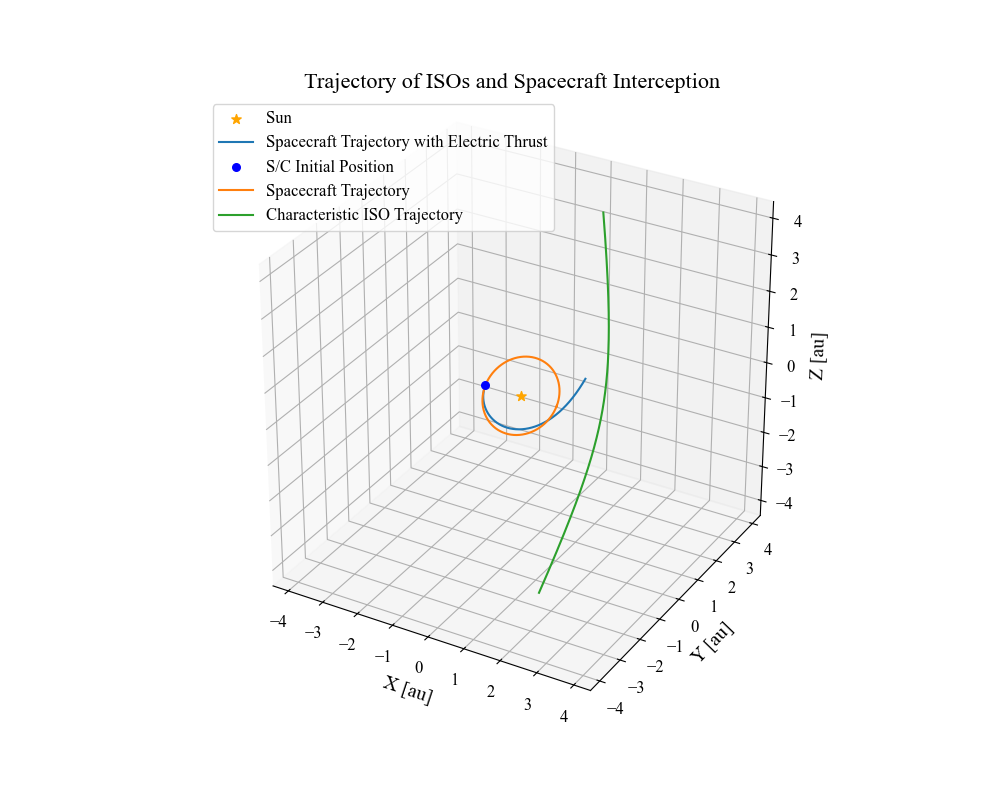

In [222]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(0, 0, 0, color='orange', s=50, label='Sun', marker='*')

ax.plot(sc_intercept_rs[0], sc_intercept_rs[1], sc_intercept_rs[2], label='Spacecraft Trajectory with Electric Thrust')
ax.scatter(r_initial.to(u.au).value[0], r_initial.to(u.au).value[1], r_initial.to(u.au).value[2], color='blue', s=30, label='S/C Initial Position')
ax.plot(sc_states[:, 0], sc_states[:, 1], sc_states[:, 2], label='Spacecraft Trajectory')

ax.plot(characteristic_iso_states[:, 0], characteristic_iso_states[:, 1], characteristic_iso_states[:, 2], label='Characteristic ISO Trajectory')

max_dist = np.amax([np.abs(oumuamua_iso_states[:, :3]), np.abs(borisov_iso_states[:, :3]), np.abs(atlas_iso_states[:, :3]), np.abs(characteristic_iso_states[:, :3])])

ax.set_xlim([-max_dist, max_dist])
ax.set_ylim([-max_dist, max_dist])
ax.set_zlim([-max_dist, max_dist])

ax.set_aspect('equal')

ax.set_xlabel('X [au]')
ax.set_ylabel('Y [au]')
ax.set_zlabel('Z [au]')
ax.set_title('Trajectory of ISOs and Spacecraft Interception')
ax.legend()

plt.show()

In [172]:
# --- Execute ---
result = analyze_interception_scenario(characteristic_heliocentric_elements, sc_elements, sim_params)

print("\n--- Analysis Result ---")
print(f"Closest Approach Time: {result['time']/86400:.2f} days from Perihelion")
print(f"Miss Distance: {result['distance_miss']:.2f} km")
print(f"Relative Velocity: {result['v_rel']:.2f} km/s")
print(f"Total Delta V: {result['total_dv']:.2f} km/s")
print(f"Constraints Met: {result['pass_constraints']}")

UnitConversionError: 'd rad' and 'rad' (angle) are not convertible